## Part 4: Modeling
For this part main goal is predict Ribbed Smoked Sheet in all business day in october 2022 and decrease mean absolute percentage error as low as possible.

In [39]:
# Import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sklearn.preprocessing import StandardScaler
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error
from sktime.forecasting.model_selection import ForecastingGridSearchCV, ExpandingWindowSplitter
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.theta import ThetaForecaster

# filter future warning for cleaner notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Function

In [40]:
def import_csv_dateindex(csv_file):
    """
    take path of csv file and return df which date col as index
    """
    df = pd.read_csv(f'../data/{csv_file}')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').asfreq('B')
    return df

In [41]:
def compare_value(y_test, preds, title=None):
    """
    plot chart compare between true and predicted values using plotly
    and calculate MAPE, RMSE scores
    """
    
    df = pd.concat([y_test, preds], axis=1)
    df.columns = ['true', 'preds']
    
    fig = go.Figure(layout = go.Layout(template='ggplot2'))

    fig.add_scatter(x=df.index, y=df['true'], line={'dash':'dash', 'color':'dodgerblue'}, name='True')
    fig.add_scatter(x=df.index, y=df['preds'], line={'color':'red'}, name='Predict')

    fig.update_layout(title=go.layout.Title(
            text=f"{title}<br><sup>MAPE is {round(mean_absolute_percentage_error(df['true'], df['preds'])*100, 2)}%</sup>\
            <br><sup>RMSE is {round(mean_squared_error(y_test, preds, square_root=True), 2)}<sup>",
            xref="paper",
            x=0))

    fig.show('png')

In [42]:
def train_test_lagged(df, endog:'series_name', exog:'list_features_name', shift:'lagged n times',
                      before_pred_date:'ending_training_date',
                      pred_date:'starting_testing_date'):
    """
    parameter
    df = dataframe
    endog = target
    exog = features
    shift = lagged time
    before_pred_date = ending date of training part
    start_testing_date = starting date of testing part
    
    return
    X and y in train test form
    
    ** This function also drop missing values automatically
    """
    df_lag = df[[endog]].copy()
    for col in exog:
        df_lag[col] = df[col].shift(shift, freq='B').copy()
    df_lag.dropna(inplace=True)
    
    X_train = df_lag[exog].loc[:before_pred_date]
    X_test = df_lag[exog].loc[pred_date:]
    y_train = df_lag[endog].loc[:before_pred_date]
    y_test = df_lag[endog].loc[pred_date:]
    
    return X_train, X_test, y_train, y_test

In [43]:
def pred_autoarima(y_train, y_test, X_train=None, X_test=None, title=None):
    """
    Predict time series data using autoarima and plot compare value between true and predicted values
    """
    arima = AutoARIMA(suppress_warnings=True)
    arima.fit(y_train, X_train)
    preds = arima.predict(fh=y_test.index, X=X_test)

    compare_value(y_test, preds, title)

    return arima

---


## Predicting RSS price

In [44]:
# import dataset from EDA part
rubber = import_csv_dateindex('../data/rubber.csv')

### Baseline Model
for baseline model will use ARIMA(AR = 1, I = 1, MA = 1) for predicting. (I(d) set to 1 for make target to be stationary)

In [45]:
# split train and test
y_train = rubber['ribbed_smoked_sheet'].loc[:'2022-07']
y_test = rubber['ribbed_smoked_sheet'].loc['2022-08':]

My goals are 
1. predict value in 2022-08 to 2022-10 which is 3 months
2. pick model that has lowest score as low as possible

In [46]:
# check that split working correctly
y_train.tail().index, y_test.head().index

(DatetimeIndex(['2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
                '2022-07-29'],
               dtype='datetime64[ns]', name='date', freq='B'),
 DatetimeIndex(['2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
                '2022-08-05'],
               dtype='datetime64[ns]', name='date', freq='B'))

In [47]:
# Base line model using arima (1, 1, 1)
arima = ARIMA(order=(1, 1, 1))
arima.fit(y_train)
preds = arima.predict(fh=y_test.index)

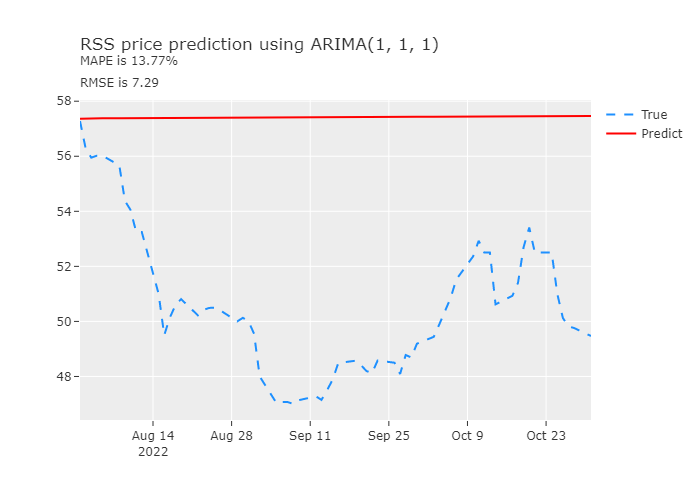

In [48]:
# compare value for using only target for prediction
compare_value(y_test, preds, 'RSS price prediction using ARIMA(1, 1, 1)')

Baseline model only predict average rss prices which is around 57 baht. So I will do gridsearch using only rss price.

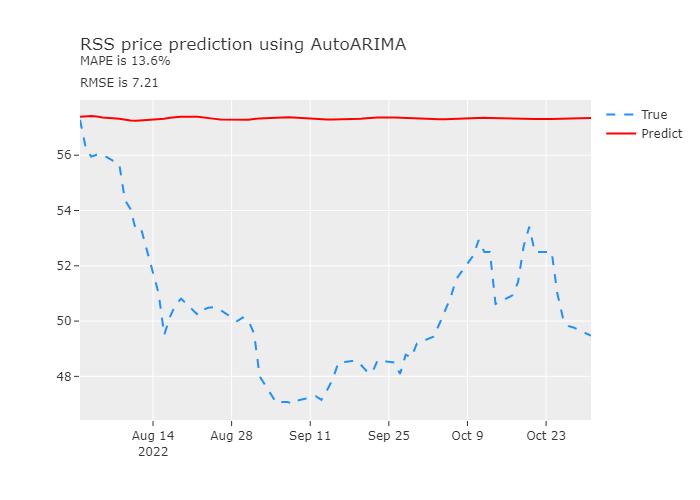

In [49]:
# use auto arima
arima = AutoARIMA(suppress_warnings=True)
arima.fit(y_train)
preds = arima.predict(fh=y_test.index)
compare_value(y_test, preds, 'RSS price prediction using AutoARIMA')

For using only target my model only predict flat line. So, my next models will include features for help predicting more precise values.

### Add features
using exogenous for predicting Ribbed Smoked Sheet need to lag for 1 month.

#### Rubber types

In [50]:
# create new dataframe which contain target and lagged features
rubber_sheet = rubber[['ribbed_smoked_sheet']].copy()
rubber_sheet['rubber_sheet_lag'] = rubber['rubber_sheet'].shift(21, freq='B').copy()
rubber_sheet.dropna(inplace=True)

In [51]:
# check that lagged data working correctly
rubber['rubber_sheet'].loc['2017'].head(), rubber_sheet['rubber_sheet_lag'].head()

(date
 2017-09-19    52.56
 2017-09-20    51.51
 2017-09-21    51.51
 2017-09-22    51.78
 2017-09-25    50.58
 Freq: B, Name: rubber_sheet, dtype: float64,
 date
 2017-10-18    52.56
 2017-10-19    51.51
 2017-10-20    51.51
 2017-10-23    51.78
 2017-10-24    50.58
 Freq: B, Name: rubber_sheet_lag, dtype: float64)

In [52]:
# split train and test
X_train = rubber_sheet['rubber_sheet_lag'].loc[:'2022-07']
X_test = rubber_sheet['rubber_sheet_lag'].loc['2022-08':]
y_train = rubber_sheet['ribbed_smoked_sheet'].loc[:'2022-07']
y_test = rubber_sheet['ribbed_smoked_sheet'].loc['2022-08':]

From pattern above I can create function for reduce redundant code As shown above in function section `train_test_lagged`.

In [53]:
# use all rubber type for predict 
X_train, X_test, y_train, y_test = train_test_lagged(rubber, 'ribbed_smoked_sheet',
                                                     ['rubber_sheet', 'latex', 'cup_lump'],
                                                     21, '2022-07', '2022-08')

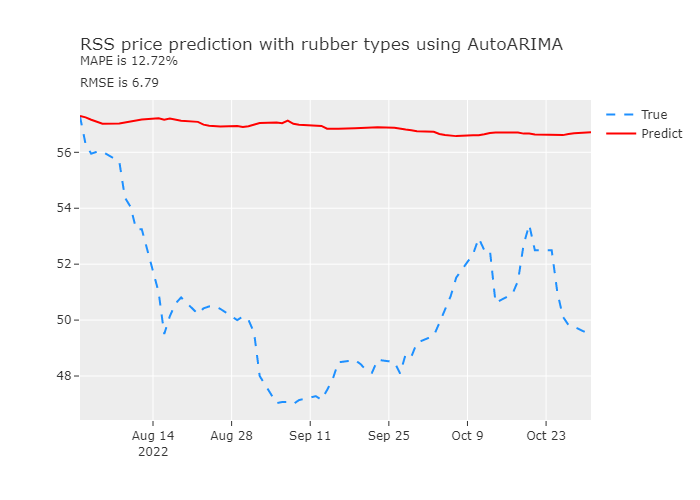

AutoARIMA(suppress_warnings=True)

In [54]:
pred_autoarima(y_train, y_test, X_train, X_test, 'RSS price prediction with rubber types using AutoARIMA')

#### Futures

In [55]:
X_train, X_test, y_train, y_test = train_test_lagged(rubber, 'ribbed_smoked_sheet', ['tocom', 'sicom'],
                                                     21, '2022-07', '2022-08')

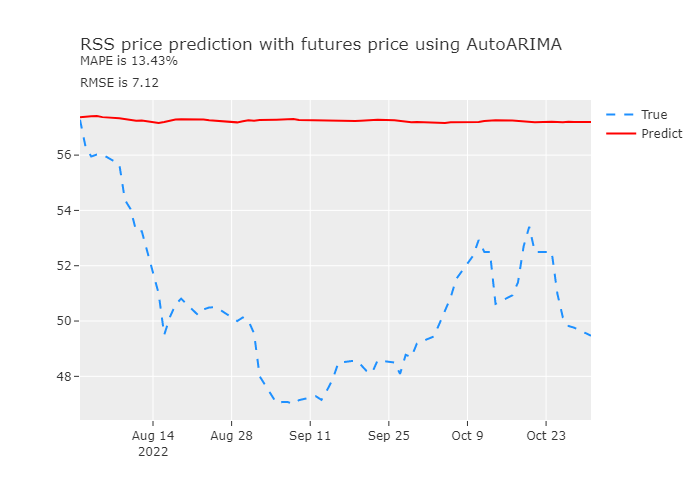

AutoARIMA(suppress_warnings=True)

In [56]:
pred_autoarima(y_train, y_test, X_train, X_test, 'RSS price prediction with futures price using AutoARIMA')

#### Currencies

In [57]:
X_train, X_test, y_train, y_test = train_test_lagged(rubber, 'ribbed_smoked_sheet', ['jpy', 'sgd'],
                                                     21, '2022-07', '2022-08')

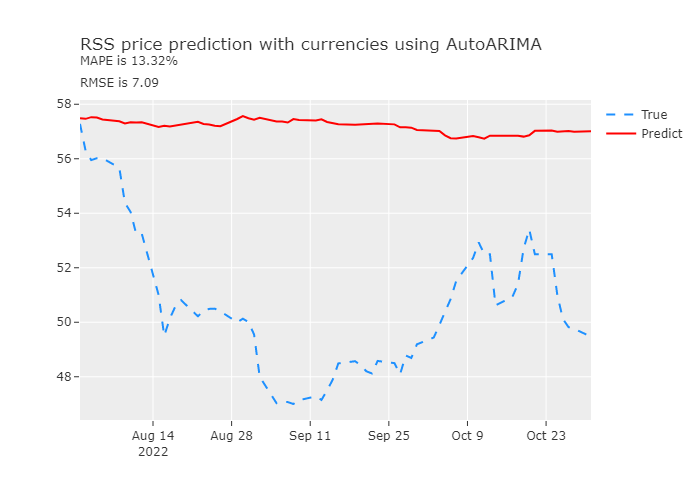

AutoARIMA(suppress_warnings=True)

In [58]:
pred_autoarima(y_train, y_test, X_train, X_test, 'RSS price prediction with currencies using AutoARIMA')

#### oil

In [59]:
X_train, X_test, y_train, y_test = train_test_lagged(rubber, 'ribbed_smoked_sheet', ['crude_oil'],
                                                     21, '2022-07', '2022-08')

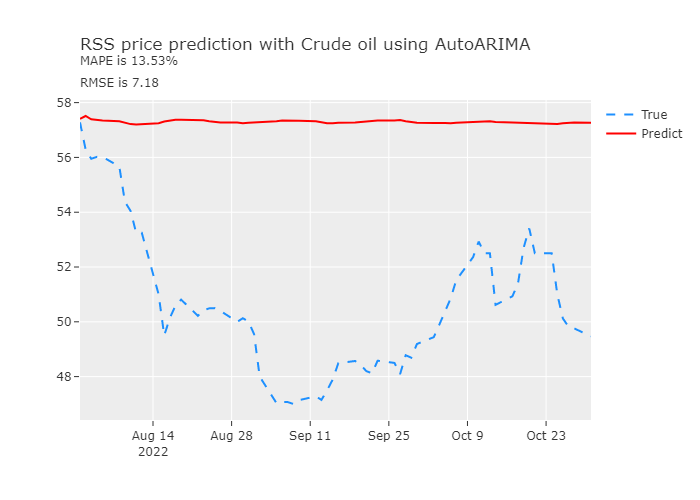

AutoARIMA(suppress_warnings=True)

In [60]:
pred_autoarima(y_train, y_test, X_train, X_test, 'RSS price prediction with Crude oil using AutoARIMA')

---
From all of models using AutoARIMA They only predicted average or flat line. So, I look back at my data.

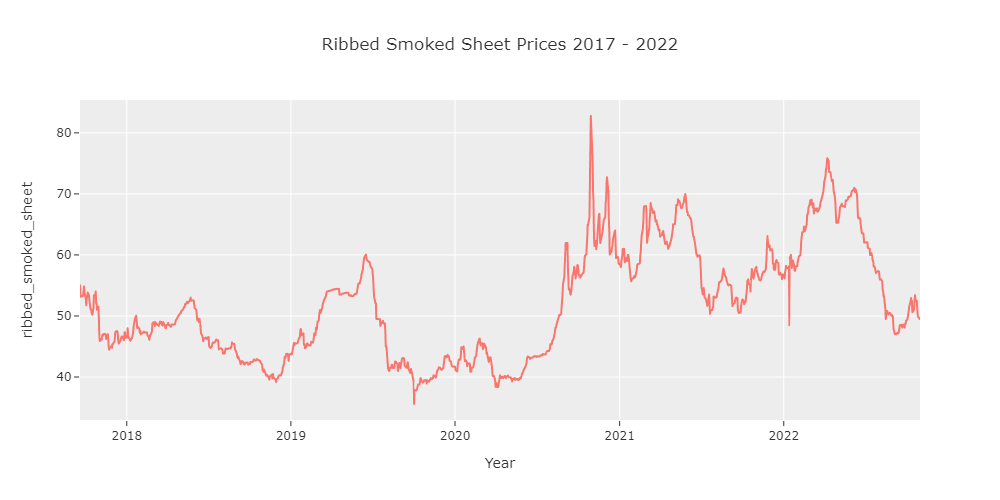

In [61]:
# plot ribbed_smoked_sheet price line chart
px.line(rubber, y="ribbed_smoked_sheet",title='Ribbed Smoked Sheet Prices 2017 - 2022',
        template='ggplot2', labels={'value':'Price', 'date':'Year'}, width=1000, height=500).show('png')

My data doesn't shown up the clear trends in daily form and also does not shown the clear pattern of seasonality base on PACF and ACF charts. I decided to move up use modern time series model which is [N-Beats]() for help my problem here.